# Introduction to Computer Vision - Lab 06

## Task 1

 Perform image classification using the neural network shown on the slide 4 of Lecture Notes 6.
 
 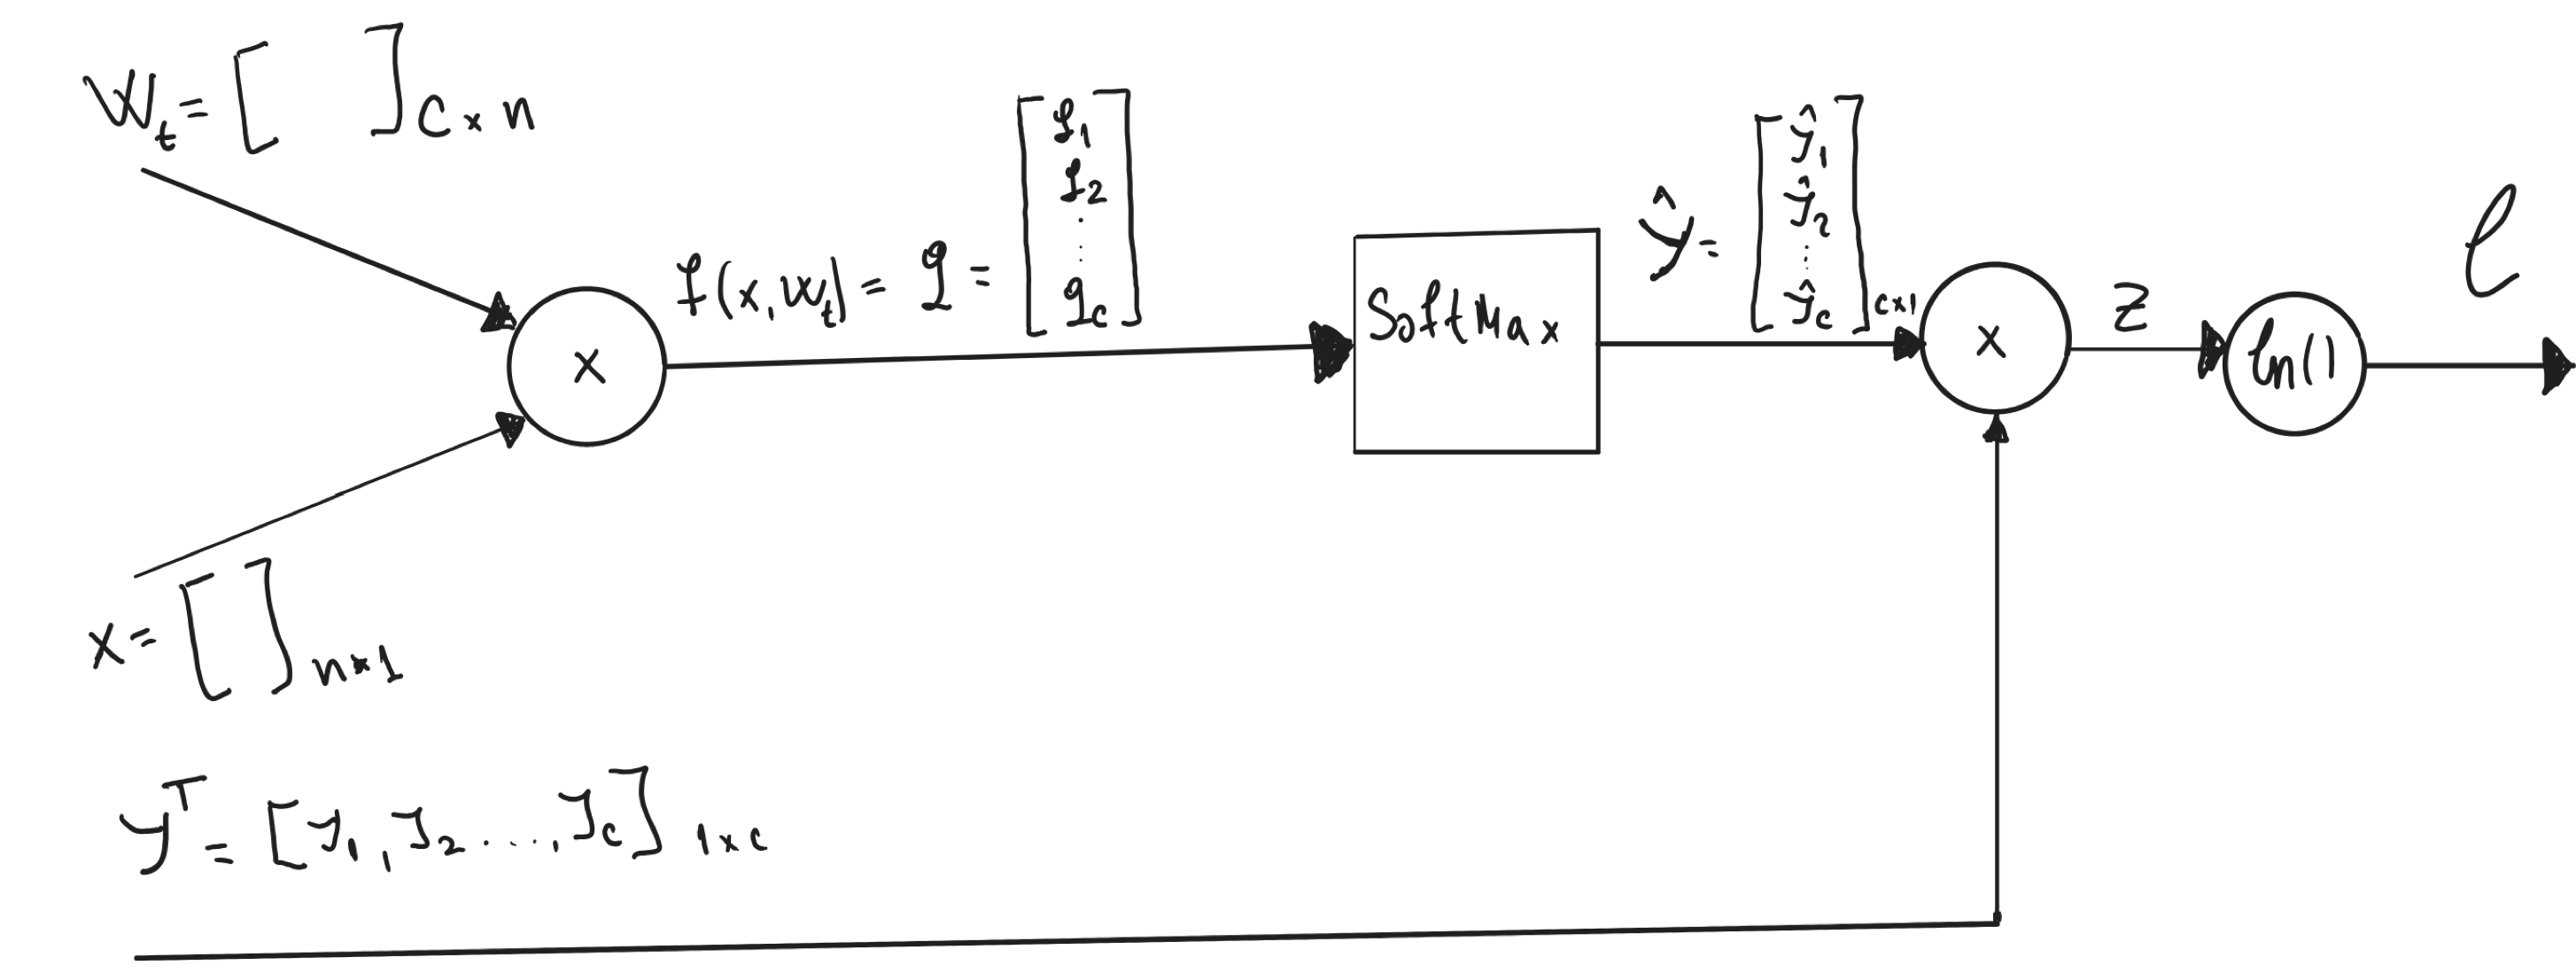

In [1]:
# import necessary libriries
import tensorflow as tf
from tensorflow.keras import datasets
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# load the dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


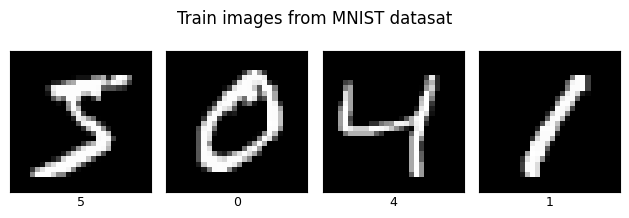

In [3]:
# plot the first images from training set with the corresponding labels
fig, axs = plt.subplots(nrows=1, ncols=4)

for i in range(4):
    ax = axs[i]
    ax.imshow(x_train[i], cmap='gray')
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax.set_title(y_train[i],
                 fontsize=9,
                 y=-0.15)

plt.suptitle('Train images from MNIST datasat',
             y=0.7)
plt.tight_layout()
plt.show()

In [4]:
# reshape the images
x_train = x_train.reshape(-1, 28*28) / 255.0
x_test = x_test.reshape(-1, 28*28) / 255.0

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [5]:
# represent each label as a true label vector with zeros and 1 on the label position
def vectorize_y(y):
    y_vec = np.zeros((len(y), 10)) # since there are 10 possible labels
    for i in range(len(y)):
        y_vec[i, y[i]] = 1
    return y_vec

# vectorize
y_train_vec = vectorize_y(y_train)
y_test_vec = vectorize_y(y_test)

print(y_train_vec[0])
print(y_train_vec.shape)
print(y_test_vec[0])
print(y_test_vec.shape)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(60000, 10)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(10000, 10)


In [6]:
# matrix multiplication node (from previous lab)
class MulNode:

    def __init__(self):
        self.w = None  # input matrix W
        self.x = None  # input values x
        self.grad = None  # gradient with respect to W (result of backward propagation)

    def forward(self, w, x):
        # calculate output of multiplication W*X
        self.w, self.x = w, x
        return np.matmul(self.w, self.x)

    def backward(self, dL_dz):
        # compute gradient with respect to W
        dz_dw = self.x.reshape((1, self.x.shape[0]))
        self.grad = np.matmul(dL_dz, dz_dw)
        return self.grad

In [7]:
# softmax node (from previous lab)
class SoftmaxNode:

    def __init__(self):
        self.y_hat = None  # output of forward propagation
        self.grad = None  # gradient with respect to the input x (result of backward propagation)

    def forward(self, x):
        # calculate output of the softmax function without normalization
        self.x = x
        e_x = np.exp(self.x)
        self.y_hat = e_x / e_x.sum(axis=0)
        return self.y_hat

    def backward(self, loss_grad):
        # compute gradients
        y_hat_i_y_hat_j = self.y_hat * np.reshape(self.y_hat, (-1, 1))
        softmax_der = np.diag(self.y_hat) - y_hat_i_y_hat_j  # derivative of softmax
        self.grad = np.dot(softmax_der, loss_grad)
        return self.grad

In [ ]:
# neural network with 1 layer
class NeuralNetwork1:

    def __init__(self):
        self.mult = MulNode()  # multiplication node
        self.softmax = SoftmaxNode()  # softmax node
        self.x, self.y = None, None  # input image pixels and labels
        self.W = None  # matrix of weights W
        self.z = None  # z value - result of y_hat*y
        self.dw = None  # gradient with respect to W


    def forward(self, W, x, y):
        # perform forward propagation
        self.x, self.y = x, y
        self.W = W
        g = self.mult.forward(self.W, self.x)
        y_hat = self.softmax.forward(g)
        self.z = np.dot(y_hat, self.y)
        # return loss l and decision label vector y_hat
        return (- np.log(self.z)), y_hat

    def backward(self, dl=1):
        # perform backpropagation and calculate gradient with respect to W
        dz = 1 / self.z * dl  # local gradient is derivative of ln
        dy_hat = np.dot(dz, np.transpose(self.y))  # local gradient is swap multiplier
        dg = self.softmax.backward(dy_hat)
        self.dw = self.mult.backward(dg.reshape((-1, 1)))
        # return gradient with repspect to W
        return self.dw

In [ ]:
# training step: perform gradient descent to obtain optimal W
def train(model, x_train, y_train_vec, max_iter, eta, epsilon):
    # initialize the weights
    W = np.random.randn(10, 28*28) * 0.01
    N = len(x_train)
    prev_loss = np.inf

    # perform gradient descent for each iteration over the training set
    for iter in range(max_iter):
        loss = 0
        correct = 0
        dW = np.zeros((10, 28*28))
        for i in range(N):
            # forward propagation
            loss_i, pred_i = model.forward(W, x_train[i], y_train_vec[i])

            # backward propagation
            dW += model.backward()

            loss += loss_i
            correct += (np.argmax(pred_i) == np.argmax(y_train_vec[i]))

        # update weights
        W += eta * 1/N * dW

        # display the average loss and train accuracy
        curr_loss = loss / N
        acc = correct / N

        print(f'Iter {iter+1}/{max_iter}: train loss= {curr_loss:.3f}, train accuracy={acc:.3f}')

        # stopping criteria:
        # if the difference of current and previos average losses is less than epsilon, stop training
        loss_difference = prev_loss - curr_loss
        if loss_difference <= epsilon:
            print("Stopping criteria met. Stop training.")
            return W

        prev_loss = curr_loss

    return


# define the stopping criteria
threshold = 0.01

# define parameters
max_iter = 50
eta = 0.1
nn_1 = NeuralNetwork1()

W = train(nn_1, x_train, y_train_vec, max_iter, eta, threshold)

Iter 1/50: train loss= 2.324, train accuracy=0.068
Iter 2/50: train loss= 2.215, train accuracy=0.343
Iter 3/50: train loss= 2.117, train accuracy=0.504
Iter 4/50: train loss= 2.026, train accuracy=0.630
Iter 5/50: train loss= 1.943, train accuracy=0.690
Iter 6/50: train loss= 1.866, train accuracy=0.720
Iter 7/50: train loss= 1.794, train accuracy=0.738
Iter 8/50: train loss= 1.728, train accuracy=0.750
Iter 9/50: train loss= 1.667, train accuracy=0.758
Iter 10/50: train loss= 1.610, train accuracy=0.765
Iter 11/50: train loss= 1.557, train accuracy=0.772
Iter 12/50: train loss= 1.508, train accuracy=0.776
Iter 13/50: train loss= 1.462, train accuracy=0.780
Iter 14/50: train loss= 1.420, train accuracy=0.784
Iter 15/50: train loss= 1.380, train accuracy=0.788
Iter 16/50: train loss= 1.343, train accuracy=0.791
Iter 17/50: train loss= 1.309, train accuracy=0.794
Iter 18/50: train loss= 1.277, train accuracy=0.797
Iter 19/50: train loss= 1.247, train accuracy=0.800
Iter 20/50: train los

In [ ]:
# test: get the predictions and evaluate the performance of an algorithm
def test(model, x_test, y_test_vec, W):
    correct = 0
    predicted_labels = []
    true_labels = []

    for i in range(len(x_test)):
        # get predictions
        _, pred = model.forward(W, x_test[i], y_test_vec[i])
        pred_label = np.argmax(pred)

        true_label = y_test[i]
        correct += (pred_label == true_label)

        predicted_labels.append(pred_label)
        true_labels.append(true_label)

    # display test accuracy
    accuracy = correct / len(x_test)
    print(f'Test accuracy: {accuracy:.3f}\n')

    # print classification report
    print(classification_report(true_labels, predicted_labels))


test(nn_1, x_test, y_test_vec, W)

Test accuracy: 0.842

              precision    recall  f1-score   support

           0       0.88      0.95      0.92       980
           1       0.86      0.96      0.90      1135
           2       0.87      0.80      0.83      1032
           3       0.76      0.87      0.81      1010
           4       0.85      0.85      0.85       982
           5       0.91      0.59      0.71       892
           6       0.85      0.90      0.88       958
           7       0.88      0.86      0.87      1028
           8       0.79      0.79      0.79       974
           9       0.80      0.82      0.81      1009

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



As can be seen, the **accuracy** of Single layer neural network on test set is **0.842**.

## Task 2
Perform image classification using the two-layer neural network shown in Slide 8 of Lecture Notes 6.

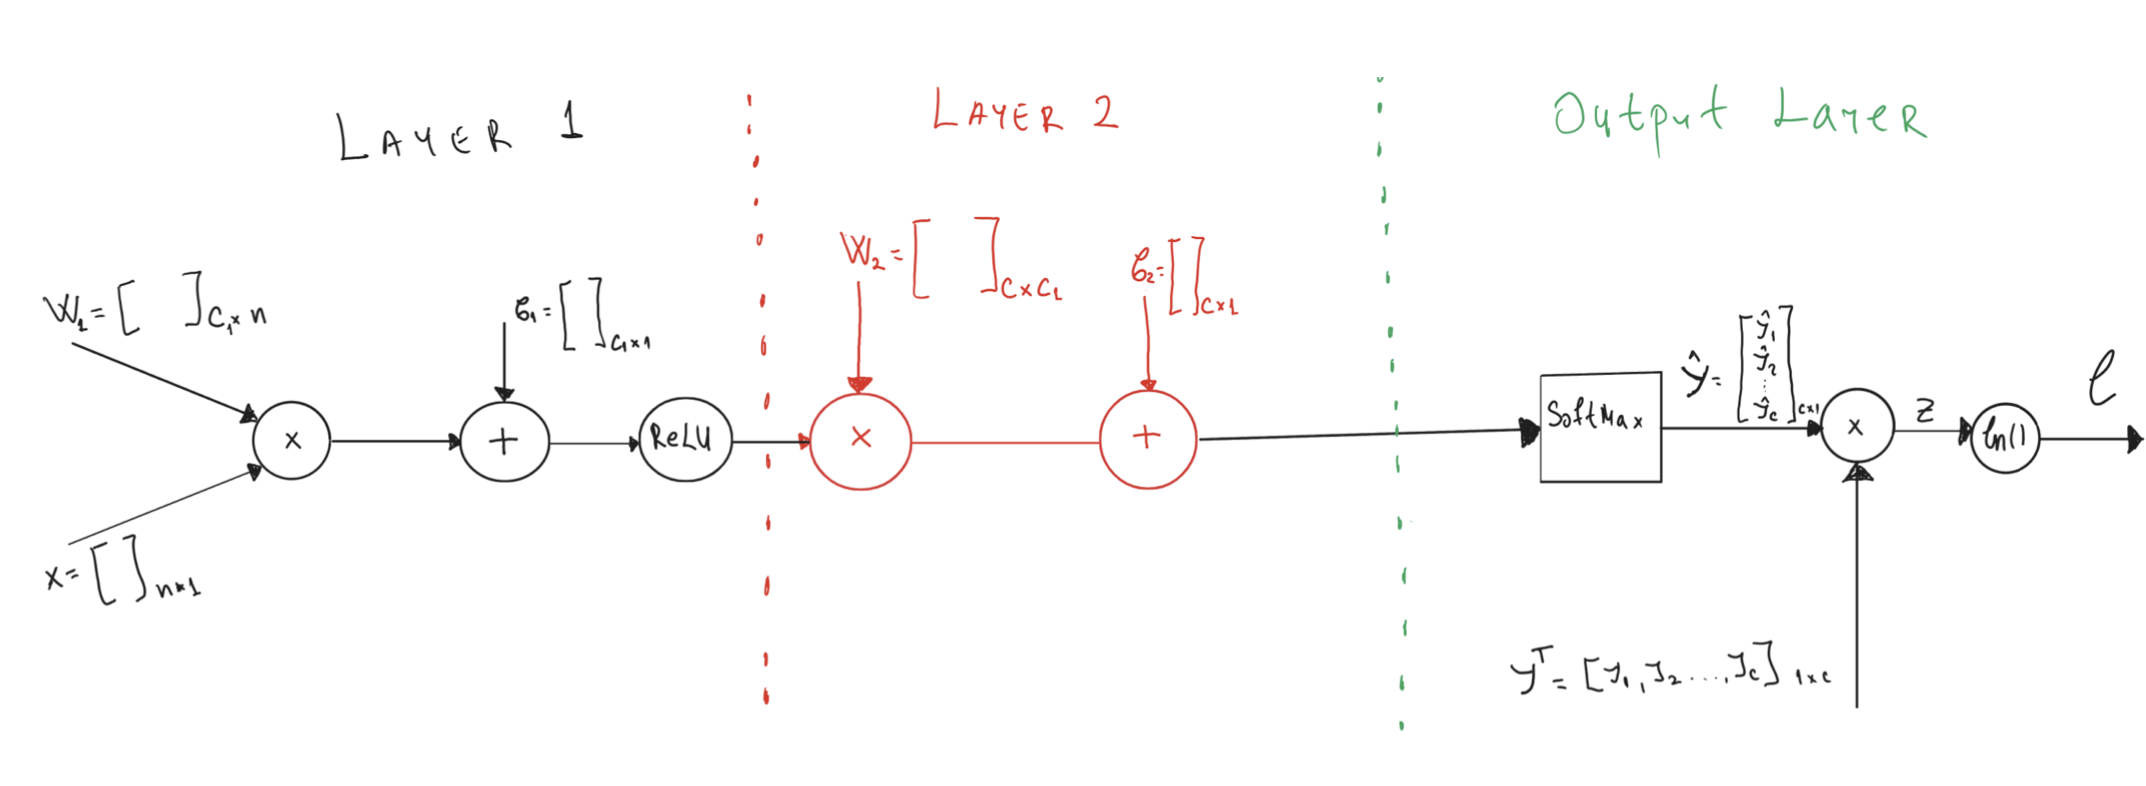

In [8]:
# relu node (from previous lab)
class ReLU:

    def __init__(self):
        self.x = None  # input values

    def forward(self, x):
        # calculate output of relu function
        self.x = x
        return np.maximum(0, self.x)

    def backward(self, loss_grad):
        # compute gradients with respect to the input values
        relu_der = np.where(self.x < 0, 0, 1) # local gradient of relu
        grad = relu_der * loss_grad
        return grad

In [9]:
# neural network with 2 layers
class NeuralNetwork2:

    def __init__(self):
        self.mult1 = MulNode()  # 1 multiplication node
        self.mult2 = MulNode()  # 2 multiplication node
        self.softmax = SoftmaxNode()  # softmax node
        self.relu = ReLU()  # relu node
        self.y_relu = None  # relu forward pass result
        self.x, self.y = None, None  # input image pixels and labels
        self.W1, self.W2 = None, None  # matrices of weights W1, W2
        self.b1, self.b2 =  None, None  # biased vectors b1, b2
        self.z = None  # z value - result of y_hat*y
        self.dw1 = None  # gradient with respect to W1
        self.dw2 = None  # gradient with respect to W2
        self.db1 = None  # gradient with respect to b1
        self.db2 = None  # gradient with respect to b2


    def forward(self, W1, W2, b1, b2, x, y):
        # perform forward propagation
        self.x, self.y = x, y
        self.W1, self.W2 = W1, W2
        self.b1, self.b2 = b1, b2
        g1 = self.mult1.forward(self.W1, self.x) + self.b1
        self.y_relu = self.relu.forward(g1)
        g2 = self.mult2.forward(self.W2, self.y_relu) + self.b2
        y_hat = self.softmax.forward(g2)
        self.z = np.dot(y_hat, self.y)
        # return loss l and decision label vector y_hat
        return (- np.log(self.z)), y_hat

    def backward(self, dl=1):
        # perform backpropagation and compute gradients with respect to W1, W2, b1 and b2
        dz = 1 / self.z * dl  # derivative of ln (1/z) multiplied by upstream gradient
        dy_hat = np.dot(dz, np.transpose(self.y))  # local gradient is swap multiplier
        dg2 = self.softmax.backward(dy_hat)
        self.db2 = dg2  # local gradient of sum (1) multiplied by upstream gradient
        ds2 = np.dot(np.transpose(self.W2), dg2)  # gradient of multiplication
        self.dw2 = self.mult2.backward(dg2.reshape((-1, 1)))
        dy_relu = self.relu.backward(ds2)
        self.db1 = dy_relu  # local gradient of sum (1) multiplied by upstream gradient
        self.dw1 = self.mult1.backward(dy_relu.reshape((-1, 1)))
        # return gradient with repspect to W1, W2, b1 and b2
        return self.dw1, self.dw2, self.db1, self.db2

In [15]:
# training step: perform gradient descent to obtain optimal W
def train(model, x_train, y_train_vec, max_iter, eta, epsilon):

    # initialize the weights and biases with hidden layer size c1=8
    W1 = np.random.randn(8, 28*28) * 0.01
    W2 = np.random.randn(10, 8) * 0.01
    b1 = np.zeros(8)
    b2 = np.zeros(10)

    N = len(x_train)
    prev_loss = np.inf

    # perform gradient descent for each iteration over the training set
    for iter in range(max_iter):
        loss = 0
        correct = 0
        dW1 = np.zeros((8, 28*28))
        dW2 = np.zeros((10, 8))
        db1 = np.zeros(8)
        db2 = np.zeros(10)

        for i in range(N):
            # forward propagation
            loss_i, pred_i = model.forward(W1, W2, b1, b2, x_train[i], y_train_vec[i])

            # backward propagation
            dW1_i, dW2_i, db1_i, db2_i = model.backward()
            dW1 += dW1_i
            dW2 += dW2_i
            db1 += db1_i
            db2 += db2_i

            loss += loss_i
            correct += (np.argmax(pred_i) == np.argmax(y_train_vec[i]))

        # update weights and biases
        W1 += eta * 1/N * dW1
        W2 += eta * 1/N * dW2
        b1 += eta * 1/N * db1
        b2 += eta * 1/N * db2


        curr_loss = loss / N
        acc = correct / N
        print(f'Iter {iter+1}/{max_iter}: train loss= {curr_loss:.3f}, train accuracy={acc:.3f}')

        # stopping criteria:
        # if the difference of current and previos loss is less than epsilon, stop training
        loss_difference = prev_loss - curr_loss
        if loss_difference <= epsilon:
            print("Stopping criteria met. Stop training.")
            return W1, W2, b1, b2

        prev_loss = curr_loss

    return


# define the stopping criteria
threshold = 0.0001

# define parameters
max_iter = 50
eta = 0.5
nn_2 = NeuralNetwork2()

W1, W2, b1, b2 = train(nn_2, x_train, y_train_vec, max_iter, eta, threshold)

Iter 1/50: train loss= 2.303, train accuracy=0.058
Iter 2/50: train loss= 2.302, train accuracy=0.112
Iter 3/50: train loss= 2.302, train accuracy=0.112
Iter 4/50: train loss= 2.301, train accuracy=0.112
Iter 5/50: train loss= 2.300, train accuracy=0.112
Iter 6/50: train loss= 2.299, train accuracy=0.112
Iter 7/50: train loss= 2.298, train accuracy=0.112
Iter 8/50: train loss= 2.296, train accuracy=0.124
Iter 9/50: train loss= 2.292, train accuracy=0.181
Iter 10/50: train loss= 2.287, train accuracy=0.249
Iter 11/50: train loss= 2.280, train accuracy=0.288
Iter 12/50: train loss= 2.269, train accuracy=0.302
Iter 13/50: train loss= 2.252, train accuracy=0.304
Iter 14/50: train loss= 2.228, train accuracy=0.305
Iter 15/50: train loss= 2.195, train accuracy=0.304
Iter 16/50: train loss= 2.150, train accuracy=0.302
Iter 17/50: train loss= 2.095, train accuracy=0.304
Iter 18/50: train loss= 2.030, train accuracy=0.311
Iter 19/50: train loss= 1.958, train accuracy=0.327
Iter 20/50: train los

In [16]:
# test: get the predictions and evaluate the performance of an algorithm
def test(model, W1, W2, b1, b2, x_test, y_test_vec):
    correct = 0
    predicted_labels = []
    true_labels = []

    for i in range(len(x_test)):
        _, pred_i = model.forward(W1, W2, b1, b2, x_test[i], y_test_vec[i])
        pred_label = np.argmax(pred_i)
        true_label = np.argmax(y_test_vec[i])

        correct += (pred_label == true_label)

        predicted_labels.append(pred_label)
        true_labels.append(true_label)

    test_acc = correct / len(x_test)
    print(f'Test accuracy: {test_acc:.3f}')

    # print classification report
    print(classification_report(true_labels, predicted_labels))


test(nn_2, W1, W2, b1, b2, x_test, y_test_vec)


Test accuracy: 0.673
              precision    recall  f1-score   support

           0       0.54      0.99      0.69       980
           1       0.93      0.94      0.94      1135
           2       0.89      0.63      0.73      1032
           3       0.62      0.78      0.69      1010
           4       0.85      0.36      0.51       982
           5       0.56      0.41      0.47       892
           6       0.83      0.82      0.82       958
           7       0.64      0.89      0.75      1028
           8       0.65      0.33      0.43       974
           9       0.46      0.51      0.49      1009

    accuracy                           0.67     10000
   macro avg       0.70      0.67      0.65     10000
weighted avg       0.70      0.67      0.66     10000



As was obtained, the **accuracy** of Two layer neural network on test set is **0.673**.